Conda Environment

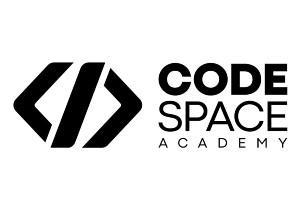

# 0.0 Importaciones y constantes

## Importaciones

In [70]:
import warnings
warnings.filterwarnings('ignore')

In [71]:
import pandas as pd
from pandas import DataFrame, concat
import joblib
import numpy as np
import datetime
import mlflow
import mlflow.sklearn
import requests
import time
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima.model import ARIMA
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

## Constantes

In [73]:
# Hiperparámetros que puedes ajustar
TEST_SIZE = 0.2
RANDOM_STATE = 42
PREDICTION_HORIZON = 4  # Número de días a predecir en el futuro

In [74]:
# Diccionario de modelos para series temporales
models = {
    'model': [
        RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, LinearRegression,
        Ridge, DecisionTreeRegressor, ExtraTreeRegressor, KNeighborsRegressor, SVR
    ],
    'model_name': [
        'RandomForestRegressor', 'GradientBoostingRegressor', 'AdaBoostRegressor', 'LinearRegression',
        'Ridge', 'DecisionTree', 'ExtraTree', 'KNeighborsRegressor', 'SVR'
    ]
}

# Diccionario de parámetros específicos y simples para cada modelo
model_params = {
    'RandomForestRegressor': {'n_estimators': 100, 'random_state': RANDOM_STATE},
    'GradientBoostingRegressor': {'n_estimators': 100, 'learning_rate': 0.1, 'random_state': RANDOM_STATE},
    'AdaBoostRegressor': {'n_estimators': 100, 'learning_rate': 1.0, 'random_state': RANDOM_STATE},
    'LinearRegression': {},
    'Ridge': {'alpha': 1.0},
    'Lasso': {'alpha': 1.0},
    'DecisionTree': {'random_state': 42},
    'ExtraTree': {'random_state': 42},
    'KNeighborsRegressor': {'n_neighbors': 5},
    'SVR': {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.1}
}

# Espacios de hiperparámetros para cada modelo
param_grid = {
    'RandomForest': {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'subsample': [0.8, 0.9, 1.0]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    'LinearRegression': {},
    'Ridge': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    'Lasso': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    'DecisionTree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'ExtraTree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'SVR': {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.1, 1.0, 10.0, 100.0],
        'epsilon': [0.01, 0.1, 1.0]
    }
}


## Funciones

In [ ]:
def plotAndComparePredictions(subset_predicciones, subset_reales):
    # Graficar las predicciones y los datos reales juntos
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=subset_predicciones, x='fecha', y='prediccion', marker='o', label='Predicción')
    sns.lineplot(data=subset_reales, x='fecha_venta', y='cantidad', marker='o', label='Datos Reales')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad')
    plt.title(f'Comparación de Predicciones y Datos Reales para el Item {item_seleccionado}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
#    Prepara los datos de entrenamiento y prueba según la configuración especificada.
def preparar_datos(ventas, config):
    item = config['item']
    day = config['day']
    n_in_daily = config['n_in_daily']
    n_in_weekly = config['n_in_weekly']
    
    df_item = ventas[ventas['articulo'] == item]
    df_item_day = df_item[df_item['fecha_venta'].dt.dayofweek == day].sort_values('fecha_venta')
    
    for i in range(1, n_in_daily+1):
        df_item_day[f'lag_{i}'] = df_item_day['cantidad'].shift(i)
    
    for i in range(1, n_in_weekly+1):
        df_item_day[f'lag_week_{i}'] = df_item_day['cantidad'].shift(i*7)
    
    df_item_day.dropna(inplace=True)
    
    X = df_item_day.drop(['cantidad', 'articulo', 'fecha_venta'], axis=1)
    y = df_item_day['cantidad']
    
    # Calcular el punto de división
    split_point = int(len(X) * (1 - TEST_SIZE))
    
    # Dividir los datos cronológicamente
    X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
    y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]
    
    # Inicializar y aplicar el escalador
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y, X.columns

#    Entrena el modelo especificado en la configuración con hiperparámetros.
def get_model_class(model_name):
    model_classes = {
        'RandomForestRegressor': RandomForestRegressor,
        'GradientBoostingRegressor': GradientBoostingRegressor,
        'AdaBoostRegressor': AdaBoostRegressor,
        'LinearRegression': LinearRegression,
        'Ridge': Ridge,
        'DecisionTree': DecisionTreeRegressor,
        'ExtraTree': ExtraTreeRegressor,
        'KNeighborsRegressor': KNeighborsRegressor,
        'SVR': SVR
    }
    return model_classes.get(model_name)

def entrenar_modelo(X_train, y_train, config):
    model_name = config['model'].split('(')[0]  # Extraer solo el nombre del modelo
    model_class = get_model_class(model_name)
    if model_class is None:
        raise ValueError(f"Modelo no reconocido: {model_name}")
    model = model_class(**model_params[model_name])
    model.fit(X_train, y_train)
    return model

#    Evalúa el modelo y calcula el error cuadrático medio.
def evaluar_modelo(model, X_test, y_test, scaler_y):
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    mse = mean_squared_error(y_test_unscaled, y_pred)
    mae = mean_absolute_error(y_test_unscaled, y_pred)
    mape = mean_absolute_percentage_error(y_test_unscaled, y_pred) * 100  # Multiplicamos por 100 para obtener el porcentaje
    # diff_avg = np.mean(np.abs(y_pred - y_test_unscaled))  # Diferencia promedio en términos de cantidad
    
    return y_pred, mse, mae, mape, # diff_avg

#    Registra los resultados del experimento en MLFlow.
def registrar_experimento(model, config, mse, mae, mape):
    """
    Registra los resultados del experimento en MLFlow.
    """
    with mlflow.start_run():
        mlflow.log_param("item", config['item'])
        mlflow.log_param("day", config['day'])
        mlflow.log_param("model", config['model'])
        mlflow.log_param("test_size", TEST_SIZE)
        mlflow.log_metric("mse", f"{mse:.2f}")
        mlflow.log_metric("mae", f"{mae:.2f}")
        mlflow.log_metric("mape", f"{mape:.2f}")
        mlflow.sklearn.log_model(model, "model")

#    Realiza predicciones para las fechas futuras.
def predecir_futuro(model, X_futuro):
    """
    Realiza predicciones para las fechas futuras.
    """
    print("se inicia la prediccion de fechas futuras:")
    return model.predict(X_futuro)

def guardar_predicciones(predicciones_eval, fechas_eval, predicciones_futuro, X_futuro, item):
    """
    Guarda las predicciones de evaluación y futuras en un dataframe.
    """
    df_eval = pd.DataFrame({
        'fecha': fechas_eval,
        'item': item,
        'prediccion': predicciones_eval,
    })
    
    df_futuro = pd.DataFrame({
        'fecha': pd.to_datetime(X_futuro['year'].astype(str) + '-' + 
                                X_futuro['month'].astype(str) + '-' + 
                                X_futuro['day'].astype(str)),
        'item': item,
        'prediccion': predicciones_futuro,
    })
    
    df_predicciones = pd.concat([df_eval, df_futuro])
    df_predicciones.set_index('fecha', inplace=True)
    return df_predicciones

def calcular_tavg_promedio(df_item, fecha, ventana_dias=7):
    """
    Calcula la temperatura promedio considerando una ventana de días antes y después de la fecha dada,
    y también para la misma fecha en años anteriores.
    """
    # Filtrar datos dentro de la ventana de días antes y después de la fecha dada
    fecha_inicio = fecha - pd.Timedelta(days=ventana_dias)
    fecha_fin = fecha + pd.Timedelta(days=ventana_dias)
    temperaturas_ventana = df_item[(df_item['fecha_venta'] >= fecha_inicio) & (df_item['fecha_venta'] <= fecha_fin)]['tavg_w']
    
    # Filtrar datos para la misma fecha en años anteriores
    temperaturas_anios_anteriores = df_item[df_item['fecha_venta'].dt.month == fecha.month]
    temperaturas_anios_anteriores = temperaturas_anios_anteriores[temperaturas_anios_anteriores['fecha_venta'].dt.day == fecha.day]['tavg_w']
    
    # Combinar las temperaturas y calcular el promedio
    temperaturas_combined = pd.concat([temperaturas_ventana, temperaturas_anios_anteriores])
    temperatura_promedio = temperaturas_combined.mean()
    
    return temperatura_promedio

def generar_datos_futuros(df_item, config, PREDICTION_HORIZON):
    """
    Genera datos futuros para predicción.
    """
    ultima_fecha = pd.to_datetime(df_item['fecha_venta']).max()
    dia_semana = config['day']
    
    # Generar fechas futuras solo para el día de la semana especificado
    fechas_futuras = pd.date_range(start=ultima_fecha + pd.Timedelta(days=1), 
                                   periods=PREDICTION_HORIZON*7, freq='D')
    fechas_futuras = fechas_futuras[fechas_futuras.dayofweek == dia_semana]
    fechas_futuras = fechas_futuras[:PREDICTION_HORIZON]  # Limitar al horizonte de predicción
    
    # Crear el DataFrame base para las fechas futuras
    X_futuro = pd.DataFrame({
        'fecha_venta': fechas_futuras,
        'day': fechas_futuras.day,
        'month': fechas_futuras.month,
        'year': fechas_futuras.year,
    })

    # Imputar temperatura promedio para las fechas futuras
    temperaturas_futuras = []
    for fecha in fechas_futuras:
        temperatura_promedio = calcular_tavg_promedio(df_item, fecha)
        temperaturas_futuras.append(temperatura_promedio)
    
    X_futuro['tavg_w'] = temperaturas_futuras

    # Predecir si es festivo (esto requeriría una fuente externa de datos de festivos)
    # Por ahora, usaremos una probabilidad basada en los datos históricos
    prob_festivo = df_item['isfestivo'].mean()
    X_futuro['isfestivo'] = np.random.choice([0, 1], size=len(X_futuro), p=[1-prob_festivo, prob_festivo])

    # Predecir lluvia (similar a festivos, idealmente usando datos meteorológicos)
    prob_lluvia = df_item['lluvia'].mean()
    X_futuro['lluvia'] = np.random.choice([0, 1], size=len(X_futuro), p=[1-prob_lluvia, prob_lluvia])

    # Generar lags
    for i in range(1, config['n_in_daily']+1):
        X_futuro[f'lag_{i}'] = np.nan
    for i in range(1, config['n_in_weekly']+1):
        X_futuro[f'lag_week_{i}'] = np.nan

    # Combinar datos históricos y futuros
    df_completo = pd.concat([df_item, X_futuro]).sort_values('fecha_venta')

    # Rellenar los lags
    for i in range(1, config['n_in_daily']+1):
        df_completo[f'lag_{i}'] = df_completo['cantidad'].shift(i)
    for i in range(1, config['n_in_weekly']+1):
        df_completo[f'lag_week_{i}'] = df_completo['cantidad'].shift(i*7)

    # Imputar valores faltantes en los lags
    imputer = SimpleImputer(strategy='mean')
    lag_columns = [col for col in df_completo.columns if col.startswith('lag')]
    df_completo[lag_columns] = imputer.fit_transform(df_completo[lag_columns])

    # Extraer solo las filas futuras
    X_futuro = df_completo[df_completo['fecha_venta'] > ultima_fecha].drop(['cantidad', 'articulo', 'fecha_venta'], axis=1)

    return X_futuro

## **DF** y **best_config**

In [75]:
# Para cargar el DataFrame desde el archivo CSV
df = pd.read_csv('data/df.csv')

# Eliminar las columnas no deseadas
df.drop(columns=['tmin_w','tmax_w','wdir_w','wspd_w','pres_w', 'orden_articulo_familia', 'precio', 'familia', 'importe'], inplace=True)

# Ordenar el DataFrame por fecha_venta de la más antigua a la más nueva
df['fecha_venta'] = pd.to_datetime(df['fecha_venta'])
df = df.sort_values('fecha_venta')
df = df.reset_index(drop=True)

f = list(df["festivo"].dropna().unique())
df["isfestivo"] = np.where(df["festivo"].isin(f), 1, 0)
df["lluvia"] = np.where(df["prcp_w"] > 0, 1, 0)

# Eliminar las columnas no deseadas
df.drop(columns=['festivo','prcp_w'], inplace=True)


df['day'] = df['fecha_venta'].dt.day
df['month'] = df['fecha_venta'].dt.month
df['year'] = df['fecha_venta'].dt.year

In [76]:
df

,articulo,fecha_venta,cantidad,tavg_w,isfestivo,lluvia,day,month,year
0,1084,2021-05-01,423.0,17.2,0,0,1,5,2021
1,6549,2021-05-01,18.0,17.2,0,0,1,5,2021
2,3880,2021-05-01,285.0,17.2,0,0,1,5,2021
3,6286,2021-05-01,165.0,17.2,0,0,1,5,2021
4,6451,2021-05-01,12.0,17.2,0,0,1,5,2021
...,...,...,...,...,...,...,...,...,...
10317,1084,2023-04-30,219.0,23.1,0,0,30,4,2023
10318,6451,2023-04-30,27.0,23.1,0,0,30,4,2023
10319,5803,2023-04-30,126.0,23.1,0,0,30,4,2023
10320,6523,2023-04-30,9.0,23.1,0,0,30,4,2023


In [77]:
df["articulo"].value_counts()

articulo
1084    730
3880    730
968     730
3960    730
1043    730
417     730
900     730
6425    729
6286    728
5803    727
6523    682
6451    657
5404    636
5403    627
6549    426
Name: count, dtype: int64

In [78]:
items = df["articulo"].sort_values().unique()
print(len(items))
items

15


array([ 417,  900,  968, 1043, 1084, 3880, 3960, 5403, 5404, 5803, 6286,
       6425, 6451, 6523, 6549], dtype=int64)

In [79]:
# Para cargar el DataFrame desde el archivo CSV
best_config = pd.read_csv('data/best_configurations.csv')
days_toNumber = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}
# Convertir los nombres de los días a números
best_config['day'] = best_config['day'].map(days_toNumber)

In [80]:
print("items: ",len(best_config["item"].value_counts()))
best_config["model"].value_counts()

items:  15


model
SVR()                                     33
Ridge()                                   28
RandomForestRegressor(random_state=42)    19
AdaBoostRegressor(n_estimators=100)       11
KNeighborsRegressor()                      9
GradientBoostingRegressor()                4
LinearRegression()                         1
Name: count, dtype: int64

In [81]:
best_config

,family,item,day,n_in_daily,n_in_weekly,mean_diff,model
0,BOLLERIA,3880,4,6,2,26.666667,GradientBoostingRegressor()
1,BOLLERIA,3880,0,3,0,26.200000,Ridge()
2,BOLLERIA,3880,5,6,1,39.533333,RandomForestRegressor(random_state=42)
3,BOLLERIA,3880,6,6,1,51.466667,AdaBoostRegressor(n_estimators=100)
4,BOLLERIA,3880,3,3,1,40.666667,Ridge()
...,...,...,...,...,...,...,...
100,PASTELERIA,6549,5,6,2,13.076923,SVR()
101,PASTELERIA,6549,6,5,0,6.461538,SVR()
102,PASTELERIA,6549,3,6,2,1.500000,RandomForestRegressor(random_state=42)
103,PASTELERIA,6549,1,2,0,3.600000,SVR()


# 1.0 Entrenamiento y compración predictiva de series con MLFlow

## Conección local
* mlflow server --host 0.0.0.0 --port 5000

In [20]:
"""
mlflow server --host 0.0.0.0 --port 5000
"""

TRACKING_URI = "http://localhost:5000"

EXPERIMENT_NAME = "predicciones"

try:
    # Establecer la URI de seguimiento de MLflow
    mlflow.set_tracking_uri(TRACKING_URI)

    # Realizar una solicitud GET a la URI de seguimiento de MLflow
    response = requests.get(TRACKING_URI, timeout=5)  # Agregamos un timeout

    # Verificar el estado de la respuesta
    if response.status_code == 200:
        print("La página de MLflow está disponible.")

        # Intentar obtener el experimento por nombre
        experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

        if experiment:
            print(f"Experimento '{EXPERIMENT_NAME}' encontrado correctamente.")
        else:
            # Si el experimento no existe, crearlo
            mlflow.create_experiment(EXPERIMENT_NAME)
            print(f"Se creó el experimento '{EXPERIMENT_NAME}' correctamente.")
    else:
        print(f"No se pudo establecer conexión con la página de MLflow. Código de estado: {response.status_code}")
except requests.ConnectionError:
    print("No se pudo establecer conexión con el servidor MLflow. Asegúrate de que el servidor esté en ejecución.")
except requests.Timeout:
    print("La conexión con el servidor MLflow ha excedido el tiempo de espera.")
except Exception as e:
    print("Ocurrió un error al intentar establecer conexión con la página de MLflow:")
    print(e)

La página de MLflow está disponible.
Experimento 'predicciones' encontrado correctamente.


## ejecución

In [83]:
# ------------------------MAIN LOOP ------------------------ #

# Inicializar un DataFrame vacío para almacenar todas las predicciones
predicciones_totales = pd.DataFrame()

for index, config in best_config.iterrows():

    print(f"Procesando configuración {index + 1} de {len(best_config)}, para el item: {config['item']}")
    try:
        X_train, X_test, y_train, y_test, scaler_X, scaler_y, feature_names = preparar_datos(df, config)
        # print(f"shapes: train {X_train.shape} test {y_test.shape} con los siguientes lags: {feature_names[6:]}")
        
        model = entrenar_modelo(X_train, y_train, config)
        y_pred, mse, mae, mape = evaluar_modelo(model, X_test, y_test, scaler_y)
        # print(f"(MSE): {mse:.2f}, (MAE): {mae:.2f}, (MAPE): {mape:.2f}%
        
        # registrar_experimento(model, config, mse, mae, mape, diff_avg)
        
        # Obtener las fechas de test y valores reales
        df_item = df[df['articulo'] == config['item']]
        fechas_test = df_item[df_item['fecha_venta'].dt.dayofweek == config['day']].iloc[-len(y_test):]['fecha_venta']
        valores_reales = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
        
        df_item = df[df['articulo'] == config['item']]
        X_futuro = generar_datos_futuros(df_item, config, PREDICTION_HORIZON)
        X_futuro_scaled = scaler_X.transform(X_futuro)
        y_pred_futuro_scaled = predecir_futuro(model, X_futuro_scaled)
        y_pred_futuro = scaler_y.inverse_transform(y_pred_futuro_scaled.reshape(-1, 1)).flatten()
        
        # Guardar predicciones de evaluación y futuras
        df_predicciones = guardar_predicciones(y_pred, fechas_test, y_pred_futuro, X_futuro, config['item'])
        # print(f"DF de predicciones (evaluación + futuras): {len(df_predicciones)} \n")
        # print(df_predicciones.shape)
        
        # Concatenar el DataFrame de predicciones al DataFrame total
        predicciones_totales = pd.concat([predicciones_totales, df_predicciones])
        
        # df_predicciones.to_csv(f'predicciones_{config["item"]}_{config["day"]}.csv', index=True)
    except Exception as e:
        print(f"Error en configuración {index + 1}: {str(e)}")

# Ordenar el DataFrame total de predicciones por fecha
predicciones_totales.sort_index(inplace=True)

predicciones_totales = predicciones_totales.reset_index()
predicciones_totales['prediccion'] = predicciones_totales['prediccion'].astype('int16')
predicciones_totales = predicciones_totales.sort_values(by='fecha').reset_index(drop=True)

print("Proceso completado.")
print(f"DF de predicciones totales: {len(predicciones_totales)} \n")
print(predicciones_totales.shape)
# Guardar el DataFrame total de predicciones si es necesario
if True:
    predicciones_totales.to_csv('data/predicciones_totales.csv', index=True)

Procesando configuración 1 de 105, para el item: 3880
se inicia la prediccion de fechas futuras:
Procesando configuración 2 de 105, para el item: 3880
se inicia la prediccion de fechas futuras:
Procesando configuración 3 de 105, para el item: 3880
se inicia la prediccion de fechas futuras:
Procesando configuración 4 de 105, para el item: 3880
se inicia la prediccion de fechas futuras:
Procesando configuración 5 de 105, para el item: 3880
se inicia la prediccion de fechas futuras:
Procesando configuración 6 de 105, para el item: 3880
se inicia la prediccion de fechas futuras:
Procesando configuración 7 de 105, para el item: 3880
se inicia la prediccion de fechas futuras:
Procesando configuración 8 de 105, para el item: 3960
se inicia la prediccion de fechas futuras:
Procesando configuración 9 de 105, para el item: 3960
se inicia la prediccion de fechas futuras:
Procesando configuración 10 de 105, para el item: 3960
se inicia la prediccion de fechas futuras:
Procesando configuración 11 d

In [45]:
predicciones_totales

,fecha,item,prediccion
0,2022-09-07,6549,8
1,2022-09-14,6549,8
2,2022-11-21,6451,6
3,2022-11-28,6451,6
4,2022-11-29,6451,8
...,...,...,...
2335,2023-05-28,900,861
2336,2023-05-28,6549,13
2337,2023-05-28,1043,192
2338,2023-05-28,5403,14


In [46]:
print(len(predicciones_totales["item"].unique()))
predicciones_totales["item"].value_counts()

15


item
417     174
1084    169
968     169
3880    168
6425    168
5803    168
6286    167
900     166
3960    164
1043    163
6451    159
5404    150
6523    137
5403    134
6549     84
Name: count, dtype: int64

In [47]:
len(items), len(predicciones_totales["item"].unique())

(15, 15)

In [60]:
# Seleccionar un solo item para comparar
item_seleccionado = 6549
subset_predicciones = predicciones_totales[predicciones_totales['item'] == item_seleccionado]
subset_reales = df[df['articulo'] == item_seleccionado]
subset_reales.drop(columns=['tavg_w','isfestivo','lluvia','day','month','year'], inplace=True)

In [64]:
subset_reales

,articulo,fecha_venta,cantidad
1,6549,2021-05-01,18.0
20,6549,2021-05-02,27.0
92,6549,2021-05-07,18.0
113,6549,2021-05-08,15.0
115,6549,2021-05-09,27.0
...,...,...,...
10223,6549,2023-04-24,9.0
10238,6549,2023-04-25,3.0
10277,6549,2023-04-28,21.0
10306,6549,2023-04-29,6.0


In [65]:
subset_predicciones

,fecha,item,prediccion
0,2022-09-07,6549,8
1,2022-09-14,6549,8
42,2022-12-12,6549,3
47,2022-12-13,6549,6
113,2022-12-18,6549,19
...,...,...,...
2254,2023-05-23,6549,6
2273,2023-05-24,6549,5
2292,2023-05-25,6549,8
2323,2023-05-27,6549,16


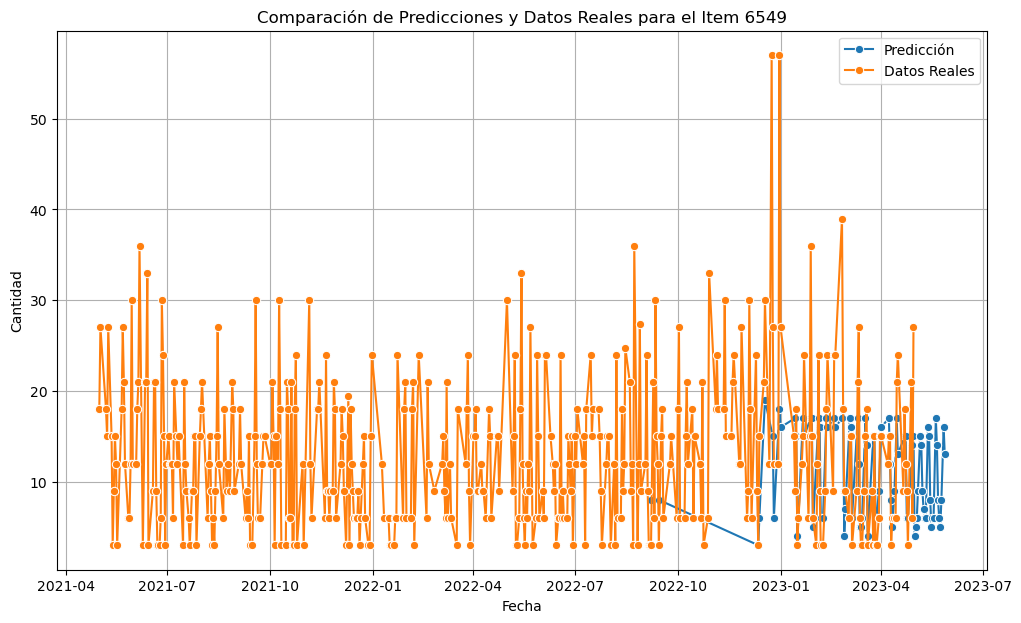

In [68]:
plotAndComparePredictions(subset_predicciones, subset_reales)

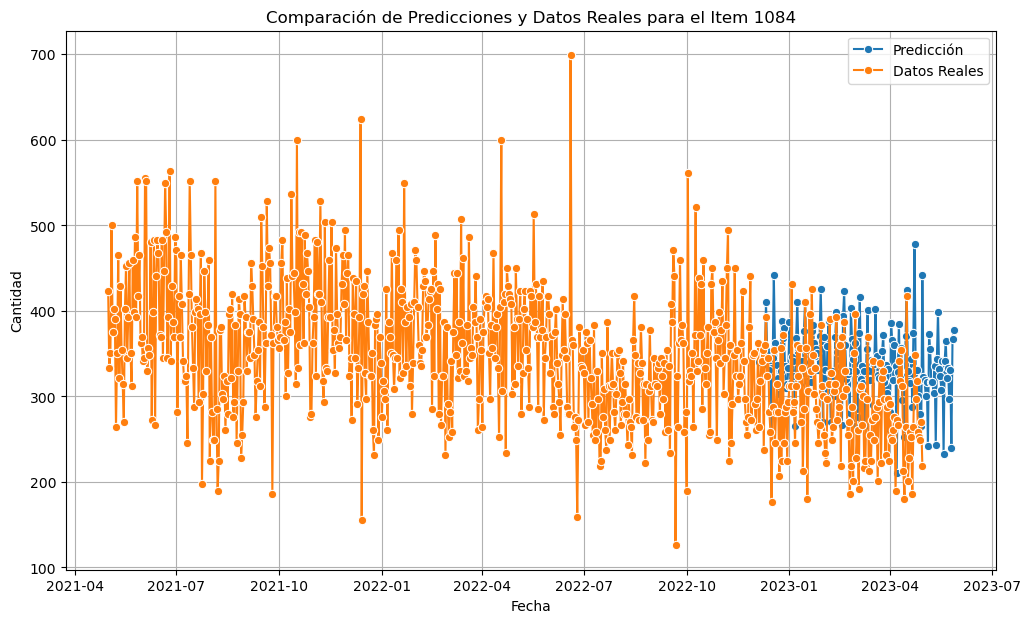

In [69]:
item_seleccionado = 1084
subset_predicciones = predicciones_totales[predicciones_totales['item'] == item_seleccionado]
subset_reales = df[df['articulo'] == item_seleccionado]
subset_reales.drop(columns=['tavg_w','isfestivo','lluvia','day','month','year'], inplace=True)
plotAndComparePredictions(subset_predicciones, subset_reales)